# Lyrics Generator - March 2021

Setup

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io

In [2]:
f = open("sheeran_john_lyrics.txt", "r")
text = f.read().lower()

text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 30
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 949783
Total chars: 82
Number of sequences: 949753


In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [4]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [5]:
epochs = 6
batch_size = 128

loss = []
lyrics = []

for epoch in range(epochs):
    history = model.fit(x, y, batch_size=batch_size, epochs=1)
    loss.append(history.history['loss'])
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.6]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print()
        lyrics.append(sentence + generated)

7420/7420 [==============================] - 69s 5ms/step - loss: 1.9151

Generating text after epoch: 0
...Diversity: 0.6
...Generating with seed: " play your music when the sun "
...Generated:  and would any time the prosent back your wild the ? kill sometime will go on me to and i can see the way i'll be one sitting on the mother of me leave you will love you like you and i live it way you want to for you. bloom (the name his fight) with right home where might stars to the room of the whore and i to preat still never hang i live and i could go on me i'll be the friend and i love to love

7420/7420 [==============================] - 36s 5ms/step - loss: 1.5668

Generating text after epoch: 1
...Diversity: 0.6
...Generating with seed: "nder the upper hand and going "
...Generated:  to be the rass of the best up for they can trying to looking like the stranger street with between me and the nass i found me good expectried stephen with your side out    i like to make me that love i was 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


...Generated:   was something where i went and i have to be back on my soul, i love now i want to be laugh i'll make me need you and the chord cause i got one her shilling gloose downwards. what we helped your face for the wears of my crown iron they watch the calls. day double there calls to the start seems to be the just go make me take it out for you, no and you're not i'm living i'm in love while i've blow b

7420/7420 [==============================] - 36s 5ms/step - loss: 1.6343

Generating text after epoch: 7
...Diversity: 0.6
...Generating with seed: "im of love what a fool you mad"
...Generated:  e his gre sight she down to go a hean thownt her fool mill jay, even to did of my the love was the browe and and yourag thes the suche when i hear you soive a fapels of gold and the stane, at a thish and i is thee .y in thes mind many bad seen you seen sheeded hinning for you flood your a) steps of find and town tire  at in the street is list, every courtris and and her to be houne wh

In [11]:
text = ""
i = 1
for sentence in lyrics:
    text += ("Epoch " + str(i) + ": ")
    text += sentence
    text += "\n"
    i += 1

f = open("generated_lyrics.txt", "w")
f.write(text)
f.close()

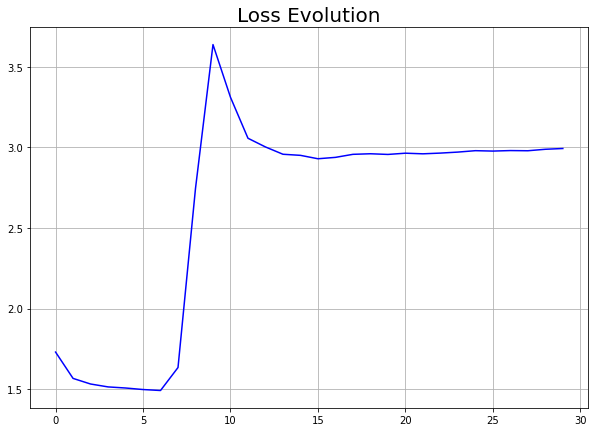

<Figure size 432x288 with 0 Axes>

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (10, 7))
ax.set_title('Loss Evolution', fontsize=20)
ax.plot(range(epochs), loss, c='blue')
plt.grid(True)
#plt.gca().set_ylim(0, 2) # set the vertical range to [0-2]
plt.show()
plt.savefig('loss_evolution_30epochs.png', transparent=True)